Running this exhaustive search on the SCF so it takes less time 

Doing a testing script with only a few variables to see if it outputs what I want 

In [16]:
import os 
import numpy as np
import pandas as pd 
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.formula.api import ols
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

In [53]:
import dask.dataframe as dd

In [58]:
os.chdir('/Users/meera/Documents/drugs/Data')
od = dd.read_csv('od_full.csv')

In [60]:
# Navigating to csv file
os.chdir('/Users/meera/Documents/drugs/Data')
od = pd.read_csv('od_full.csv')



In [61]:
#for the modeling we have to drop the null values 
od_nonull = od[od['Overdose_Deaths'].notna()]
od_nonull = od_nonull.drop(['Pct_Majority_Income_to_Housing',
                            'Pct_Child_Free_Lunch', 'Premature_Deaths',
                            'Violent_Crime_Rate_per_100k', 'HIV_Rate_per_100k'], axis = 1)

#now we drop all the na values 
od_nonull = od_nonull.dropna(axis = 0)
od_nonull.isnull().sum()

Year                         0
FIPS                         0
County                       0
State                        0
Region                       0
Division                     0
Overdose_Deaths              0
Overdose_Pop                 0
Overdose_Rate_per_100k       0
Population                   0
Pct_Age<18                   0
Pct_Age>=65                  0
Pct_Black                    0
Pct_Native                   0
Pct_Asian                    0
Pct_Pacific_Islander         0
Pct_Hispanic                 0
Pct_Not_Prof_in_Eng          0
Pct_Female                   0
Pct_Rural                    0
Pct_Diabetes                 0
Potential_Years_Lost         0
Pct_Low_Weight_Births        0
Pct_Smokers                  0
Pct_Adults_Obsese            0
Pct_Excessive_Drinking       0
Pct_DUI_Deaths               0
Teen_Birth_Rate_per_100k     0
Pct_Uninsured                0
PrimCarePhys_per_100k        0
Pct_HS_Grad                  0
Pct_College_Edu              0
Pct_Chil

In [62]:
#od_nonull.to_csv("od_nonull.csv", index = False)

With out the null columns dropped we see that there is 31420 rows and 50 columns. LOL with the null values dropped from the OD deaths we now have 7497 rows and 50 columns 

Also it should be noted that we are using the years from 2011 to 2020 !!! Meep great stuff :) 

In [39]:
od_nonull.columns

Index(['Year', 'FIPS', 'County', 'State', 'Region', 'Division',
       'Overdose_Deaths', 'Overdose_Pop', 'Overdose_Rate_per_100k',
       'Population', 'Pct_Age<18', 'Pct_Age>=65', 'Pct_Black', 'Pct_Native',
       'Pct_Asian', 'Pct_Pacific_Islander', 'Pct_Hispanic',
       'Pct_Not_Prof_in_Eng', 'Pct_Female', 'Pct_Rural', 'Pct_Diabetes',
       'Potential_Years_Lost', 'Pct_Low_Weight_Births', 'Pct_Smokers',
       'Pct_Adults_Obsese', 'Pct_Excessive_Drinking', 'Pct_DUI_Deaths',
       'Teen_Birth_Rate_per_100k', 'Pct_Uninsured', 'PrimCarePhys_per_100k',
       'Pct_HS_Grad', 'Pct_College_Edu', 'Pct_Children_in_Poverty',
       'Pct_Child_in_1ParentHH', 'Opioid_Disp_Rate_per_100k', 'Pct_Unemployed',
       'Pct_Poverty', 'Median_HHI', 'Jail_Pop', 'Urbanicity', 'Spatial_Max',
       'Spatial_Mean', 'Prev_Spatial_Max', 'Prev_Spatial_Mean', 'Geometry'],
      dtype='object')

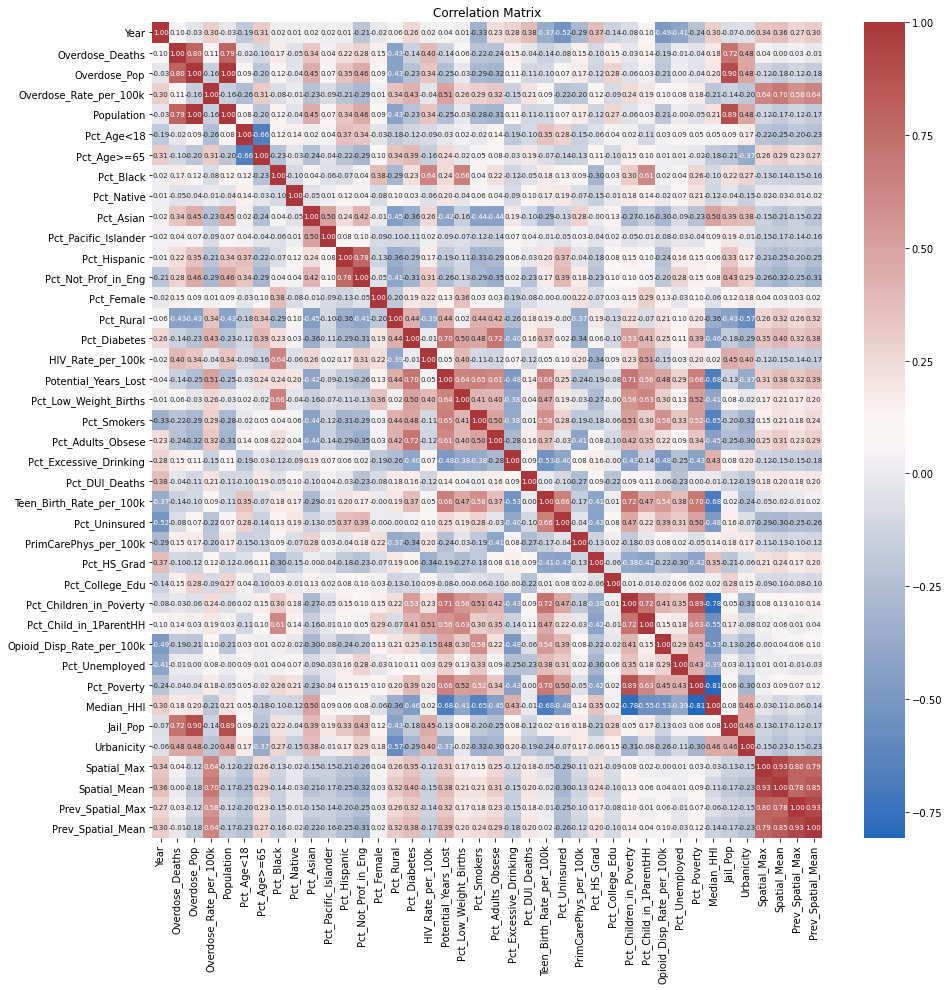

In [32]:
fig, ax = plt.subplots(figsize=(15,15)) 
correlation_mat = od_nonull.drop(['FIPS'], axis=1).corr()
sns.heatmap(correlation_mat, annot = True, ax=ax, annot_kws={"fontsize":7}, fmt='.2f', cmap='vlag') # icefire, coolwarm, vlag
plt.title("Correlation Matrix") 
plt.show()

<AxesSubplot:>

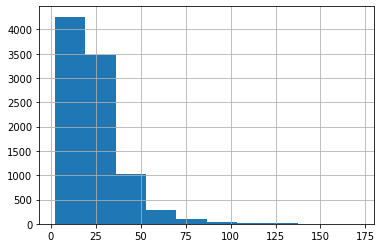

In [11]:
od_nonull['Overdose_Rate_per_100k'].hist()

In [40]:
#taking the log transform of this variable for the modeling !! 
#Also it should be noted that we are not going to standardize our predictors just yet !

od_y = np.log(od_nonull['Overdose_Rate_per_100k'])

<AxesSubplot:>

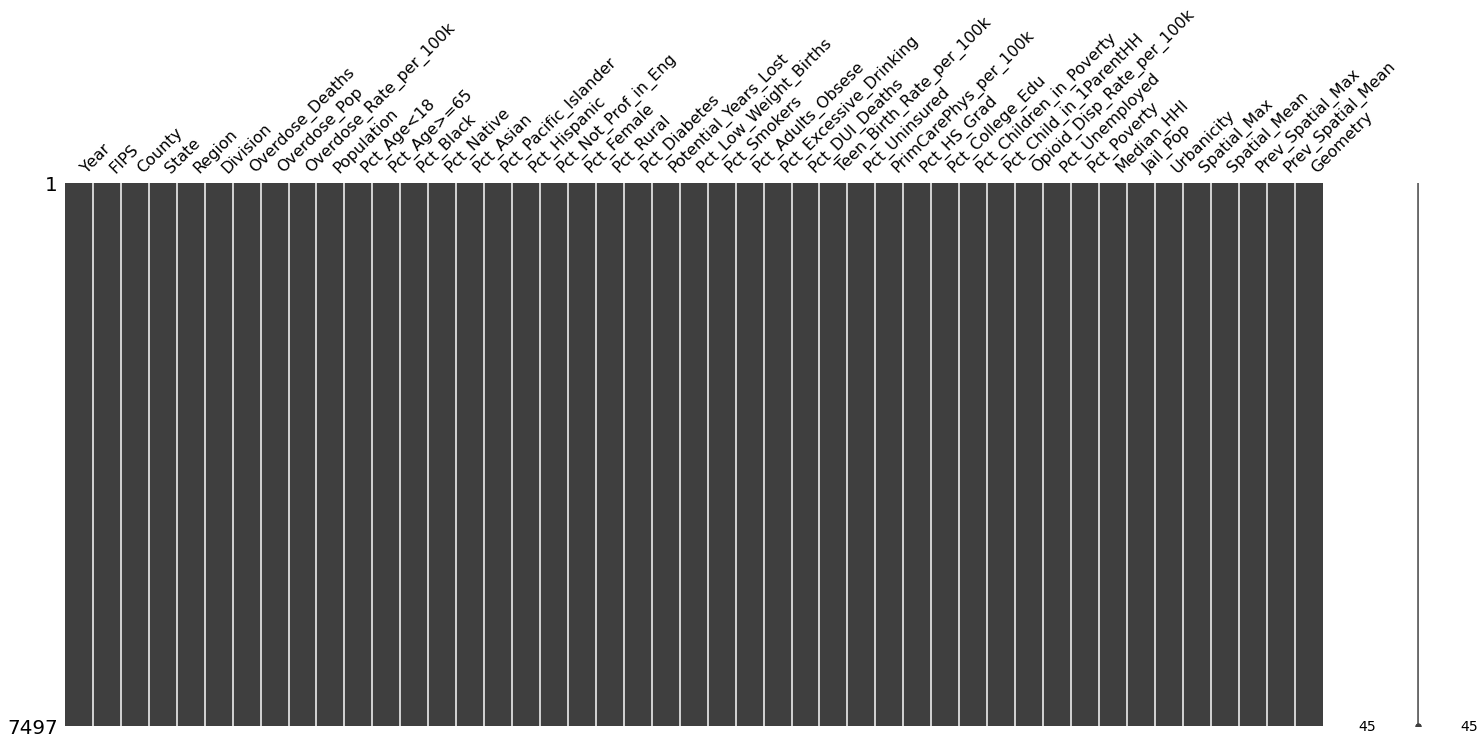

In [47]:
msno.matrix(od_nonull)

In [41]:
#tiny guy for test 
od_x = od_nonull[['Pct_Rural', 'Pct_Diabetes', 
                 'Prev_Spatial_Max', 'Prev_Spatial_Mean',
                 'Pct_Smokers', 'Pct_Excessive_Drinking']]

In [45]:
#for big boy 
od_x = od_nonull[['Year',
       'Population', 'Pct_Age<18', 'Pct_Age>=65', 'Pct_Black', 'Pct_Native',
       'Pct_Asian', 'Pct_Pacific_Islander', 'Pct_Hispanic',
       'Pct_Not_Prof_in_Eng', 'Pct_Female', 'Pct_Rural', 'Pct_Diabetes',
       'Potential_Years_Lost', 'Pct_Low_Weight_Births', 'Pct_Smokers',
       'Pct_Adults_Obsese', 'Pct_Excessive_Drinking', 'Pct_DUI_Deaths',
       'Teen_Birth_Rate_per_100k', 'Pct_Uninsured', 'PrimCarePhys_per_100k',
       'Pct_HS_Grad', 'Pct_College_Edu', 'Pct_Children_in_Poverty',
       'Pct_Child_in_1ParentHH', 'Opioid_Disp_Rate_per_100k', 'Pct_Unemployed',
       'Pct_Poverty', 'Median_HHI', 'Jail_Pop', 'Urbanicity', 'Spatial_Max',
       'Spatial_Mean', 'Prev_Spatial_Max', 'Prev_Spatial_Mean']]

In [43]:
# Run exhaustive search with linear regression

y = np.array(od_y)

X = np.array(od_x)

lr = LinearRegression()

efs = EFS(lr, 
          min_features=5,
          max_features=16,
          scoring='neg_mean_squared_error',
          cv=5,
          print_progress = True,
          n_jobs = 2)

efs.fit(X, y)

print('Best MSE score: %.2f' % efs.best_score_ * (-1))
print('Best subset:', efs.best_idx_)

Features: 41/41


Best subset: (1, 3, 5)
